In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

# First, look for column headers
first_row = session.query(Measure).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fccbe735dd0>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [117]:
# inspector can also be used to examine table names and their respective column names and data types
inspector = inspect(engine)

for tables in inspector.get_table_names():
    print(f"'{tables}' column headers (TYPE):")
    print("    ")
    columns = inspector.get_columns(tables)
    for c in columns:
        print(f'{c["name"]} ({c["type"]})')
    print("----------------")
    print("   ")

'measurement' column headers (TYPE):
    
id (INTEGER)
station (TEXT)
date (TEXT)
prcp (FLOAT)
tobs (FLOAT)
----------------
   
'station' column headers (TYPE):
    
id (INTEGER)
station (TEXT)
name (TEXT)
latitude (FLOAT)
longitude (FLOAT)
elevation (FLOAT)
----------------
   


In [118]:
# Then, extract most recent date by sorting dates in descending order and returning the first value
recent_date = session.query(Measure).order_by((Measure.date).desc()).first()
recent_date.date

'2017-08-23'

            Precipitation
Date                     
2016-08-24           1.45
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.15
2016-08-24           2.28
...                   ...
2017-08-22           0.00
2017-08-23           0.45
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00

[2015 rows x 1 columns]
           Date  Precipitation
0    2016-08-24           9.33
1    2016-08-25           0.54
2    2016-08-26           0.10
3    2016-08-27           0.32
4    2016-08-28           3.10
..          ...            ...
360  2017-08-19           0.09
361  2017-08-20           0.01
362  2017-08-21           0.58
363  2017-08-22           0.50
364  2017-08-23           0.53

[365 rows x 2 columns]


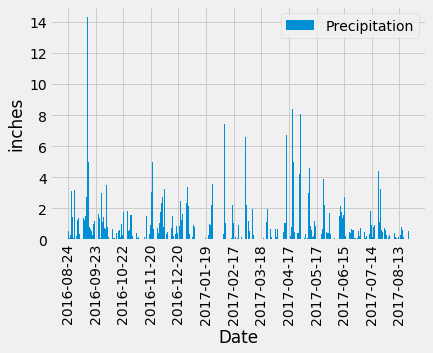

In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
yr_ago = (dt.strptime(recent_date.date, '%Y-%m-%d'))+relativedelta(years=-1)


# Perform a query to retrieve the data and precipitation scores
last_yr_precip = session.query(Measure).filter(Measure.date >= yr_ago).order_by((Measure.date).desc()).all()

measuredate=[]
precip=[]

for row in last_yr_precip:
    # print(row.date, row.prcp)
    measuredate.append(row.date)
    precip.append(row.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
last_yr_precip_df = pd.DataFrame({'Date': measuredate,
                                 'Precipitation':precip}).set_index('Date')            

# Sort the dataframe by date
last_yr_precip_df.sort_index(inplace=True)

# Remove rows with NaN prcp values and print df
clean_last_year = last_yr_precip_df.dropna()
print(clean_last_year)

# Groupby 'Date' and print df
gb=clean_last_year.groupby('Date')['Precipitation'].sum().reset_index(name='Precipitation')
print(gb)


# Use Pandas Plotting with Matplotlib to plot the clean data summed by date
fig, ax = plt.subplots()
ax.bar(gb['Date'],gb['Precipitation'])
plt.xlabel("Date")
plt.ylabel("inches")
plt.xticks(np.arange(0,len(gb['Date']),29.5),rotation=90)
plt.legend(['Precipitation'])
plt.show()






In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
gb.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [111]:
# Design a query to calculate the total number stations in the dataset

len(session.query(Station.station).group_by(Station.station).all())


9

In [134]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


station_activity = session.query(Measure).all()
# ------------------
id=[]
station=[]
temp=[]

for row in station_activity:
    # print(row.id, row.station)
    id.append(row.id)
    station.append(row.station)
    temp.append(row.tobs)

station_activity_df = pd.DataFrame({'id': id,
                                 'station code':station,'temp':temp}).set_index('id')            

# Sort the dataframe by date
station_activity_df.sort_index(inplace=True)

# Remove rows with NaN prcp values and print df
clean_station = station_activity_df.dropna()


# Groupby 'Date' and print df
gbstat=clean_station.groupby('station code')['temp'].count().reset_index(name='entry count').sort_values(by=['entry count'],ascending=False)
gbstats=gbstat.reset_index(drop=True)
print(gbstats)

  station code  entry count
0  USC00519281         2772
1  USC00519397         2724
2  USC00513117         2709
3  USC00519523         2669
4  USC00516128         2612
5  USC00514830         2202
6  USC00511918         1979
7  USC00517948         1372
8  USC00518838          511


In [136]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measure.station,
       func.min(Measure.tobs),
       func.max(Measure.tobs),
       func.avg(Measure.tobs)]
USC00519281_temp_stats = session.query(*sel).\
    filter(Measure.station == "USC00519281").all()
USC00519281_temp_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [137]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# extract most recent date by sorting dates in descending order and returning the first value
recent_USC00519281_date = session.query(Measure).order_by((Measure.date).desc()).filter(Measure.station == "USC00519281").first()
recent_USC00519281_date.date

'2017-08-18'

In [138]:
# Calculate the date one year from the last date in data set.
yr_ago = (dt.strptime(recent_USC00519281_date.date, '%Y-%m-%d'))+relativedelta(years=-1)

In [139]:
# Perform a query to retrieve the data and temperature values
last_yr_temp = session.query(Measure).filter(Measure.date >= yr_ago).filter(Measure.station == "USC00519281").order_by((Measure.date).desc()).all()

stationname = []
tempmeasuredate=[]
temp=[]

for row in last_yr_temp:
    # print(row.station,row.date, row.tobs)
    stationname.append(row.station)
    tempmeasuredate.append(row.date)
    temp.append(row.tobs)

USC00519281 2017-08-18 79.0
USC00519281 2017-08-17 76.0
USC00519281 2017-08-16 76.0
USC00519281 2017-08-15 77.0
USC00519281 2017-08-14 77.0
USC00519281 2017-08-13 77.0
USC00519281 2017-08-06 83.0
USC00519281 2017-08-05 82.0
USC00519281 2017-08-04 77.0
USC00519281 2017-07-31 76.0
USC00519281 2017-07-30 81.0
USC00519281 2017-07-29 82.0
USC00519281 2017-07-28 81.0
USC00519281 2017-07-27 76.0
USC00519281 2017-07-26 75.0
USC00519281 2017-07-25 77.0
USC00519281 2017-07-24 75.0
USC00519281 2017-07-23 82.0
USC00519281 2017-07-22 77.0
USC00519281 2017-07-21 77.0
USC00519281 2017-07-20 77.0
USC00519281 2017-07-19 76.0
USC00519281 2017-07-18 76.0
USC00519281 2017-07-17 76.0
USC00519281 2017-07-16 80.0
USC00519281 2017-07-15 80.0
USC00519281 2017-07-14 76.0
USC00519281 2017-07-13 74.0
USC00519281 2017-07-12 74.0
USC00519281 2017-07-11 72.0
USC00519281 2017-07-10 69.0
USC00519281 2017-07-09 78.0
USC00519281 2017-07-08 78.0
USC00519281 2017-07-07 75.0
USC00519281 2017-07-06 74.0
USC00519281 2017-07-

In [169]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
last_yr_USC00519281_temp_df = pd.DataFrame({'Date': tempmeasuredate,
                                 'Temperature':temp})
last_yr_USC00519281_temp_df.sort_index(inplace=True)

# Drop NaN temp measurements
clean_last_year_temp = last_yr_USC00519281_temp_df.dropna()

# Groupby on Temperature values to give number of days at each temperature over 12 month period
gbt=clean_last_year_temp.groupby('Temperature')['Date'].count().reset_index(name='Days')
print(gbt)




    Temperature  Days
0          59.0     3
1          60.0     2
2          61.0     1
3          62.0     6
4          63.0     4
5          64.0     3
6          65.0     7
7          66.0     5
8          67.0    15
9          68.0    12
10         69.0    19
11         70.0    22
12         71.0    18
13         72.0    22
14         73.0    18
15         74.0    39
16         75.0    33
17         76.0    33
18         77.0    31
19         78.0    23
20         79.0    20
21         80.0    11
22         81.0     5
23         82.0     3
24         83.0     1


   Temperature  Days
0    59.0-61.0     5
1    61.0-63.0     7
2    63.0-65.0     7
3    65.0-67.0    12
4    67.0-69.0    27
5    69.0-71.0    41
6    71.0-73.0    40
7    73.0-75.0    57
8    75.0-77.0    66
9    77.0-79.0    54
10   79.0-81.0    31
11   81.0-83.0     9


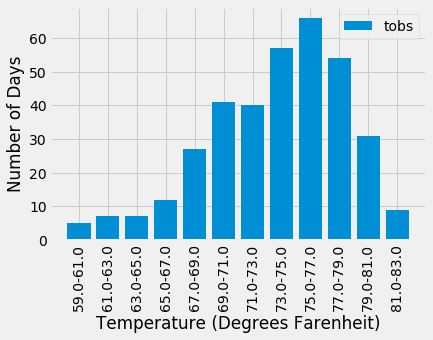

In [170]:
# Use Pandas Plotting with Matplotlib to plot the data with bins = 12

# Create 12 equal width bins on Temperature using min, max values
bins = []
labels = []
for i in range(0,13):
    bins.append((min(gbt['Temperature'])-.01) + (i*(((max(gbt['Temperature'])+.01)-min(gbt['Temperature']))/12)))
    if i != 0:
        labels.append(f'{bins[i-1]:.1f}-{bins[i]:.1f}')
gbt['bin'] = pd.cut(gbt['Temperature'], bins=bins, labels=labels)

# Groupby on bins
gbt_binned = gbt.groupby('bin')['Days'].sum().reset_index(name='Days')
gbt_binned.columns = ['Temperature','Days']
print(gbt_binned)

# Plot frequency of temperature readings as histogram including xlabel, ylabel and legend
fig, ax = plt.subplots()
ax.bar(gbt_binned['Temperature'],gbt_binned['Days'])
plt.xlabel("Temperature (Degrees Farenheit)")
plt.ylabel("Number of Days")
plt.xticks(np.arange(0,13,1),rotation=90)
plt.legend(['tobs'])
plt.show()

# Close session

In [ ]:
# Close Session
session.close()